In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
import yfinance as yf
import random
from scipy.optimize import minimize

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False
# (*) To communicate with Plotly's server, sign in with credentials file
import plotly as py  

# (*) Useful Python/Plotly tools
import plotly.tools as tls   

# (*) Graph objects to piece together plots
from plotly.graph_objs import *

import cufflinks

In [90]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

def random_portfolio(TREASURY_BILL_RATE, returns, mutate = False, weights = None):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''
    if mutate is True and weights is not None:
        w = weights
        position = random.sample(range(0,len(w)),1)
        np.put(w, position, np.random.rand(1))
        w = w / sum(w)
        w = w.astype(float)
    elif weights is not None:
        w = weights
    else:
        w = rand_weights(returns.shape[0])
        
        
    p = np.asmatrix(np.mean(returns, axis=1))
    
    C = np.asmatrix(np.cov(returns))
    
    mu = np.asmatrix(w) * p.T
    sigma = np.sqrt(np.asmatrix(w) * C * np.asmatrix(w).T)
    
    #print([mu,sigma])
    #returns = np.dot(weights, returns_annual)
    #volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    #sharpe = (returns - TREASURY_BILL_RATE) / volatility
    #sharpe_ratio.append(sharpe)
    
    sharpe = (mu-TREASURY_BILL_RATE)/sigma
    
    # This recursion reduces outliers to keep plots pretty
    #if sigma > 2:
        #return random_portfolio(returns, w = None)
    return np.float(mu), np.float(sigma), np.float(sharpe), np.array(w,dtype=object)

#derive efficient frontier
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    #weights = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[len(m1)-1] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    #wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    #sr = np.array(returns)/np.array(risks)
    return returns, risks

def optimize_sharpe_ratio(returns, TREASURY_BILL_RATE = None):
    
    r1=returns
    #((((np.exp(returns))-1)*252.75)+1- TREASURY_BILL_RATE)/100
    r = r1 *-1
    
    def sharpe_portfolio(w):
        ''' 
        Returns the mean and standard deviation of returns for a random portfolio
        '''        
        p = np.asmatrix(np.mean(r, axis=1))

        C = np.asmatrix(np.cov(r1))

        mu = np.asmatrix(w) * p.T
        sigma = np.sqrt(np.asmatrix(w) * C * np.asmatrix(w).T)

        sharpe = mu/sigma

        # This recursion reduces outliers to keep plots pretty
        #if sigma > 2:
            #return random_portfolio(returns, w = None)
        return np.float(sharpe)

    res = minimize(sharpe_portfolio, rand_weights(len(r)).reshape(-1, 1),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
      ],
      bounds=[(0., 1.) for i in range(len(r))])

    return(random_portfolio(r1, False, res.x))

def _variance(covariance_matrix, w):
    return (w.reshape(-1, 1).T @ covariance_matrix @ w.reshape(-1, 1))[0][0]

def get_ret_vol_sr(weights,returns):
    
    p = np.asmatrix(np.mean(returns, axis=1))
    w = weights
    C = np.asmatrix(np.cov(returns))
    
    mu = np.asmatrix(w) * p.T
    sigma = np.sqrt(np.asmatrix(w) * C * np.asmatrix(w).T)
    
    sharpe = mu/sigma
    
    return np.array([mu, sigma, sharpe])

def dl(stock, start, end):
    subset = yf.download(stock, start=start, end=end, auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')
    subset = subset[start:end]
    subset2 = subset[start:end]
    if (len(subset) != 0) and (len(subset2)!=0):
        return (subset)


import pandas as pd
end = pd.Timestamp.utcnow()
start = (end - 2500 * pd.tseries.offsets.BDay())
start = start.strftime('%Y-%m-%d')
end = end.strftime('%Y-%m-%d')


In [8]:
symbols = ['IBM', 'GLD', 'XOM', 'AAPL', 'MSFT', 'TLT', 'SHY']


stocks = []
for i in symbols:
    stocks.append(dl(i,start,end))



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
stocks_df = pd.DataFrame()
for i in range(0,len(symbols)):
    stocks_df = pd.concat([stocks_df,pd.DataFrame(stocks[i]).iloc[:,3]],axis=1)
    
stocks_df.columns = symbols

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
return_vec = np.zeros(shape=(len(stocks),len(stocks[0].iloc[:,3])-1))

for i in range(0,len(stocks)):
    intArray = np.array(np.log(1+stocks[i].iloc[:,3].pct_change().dropna()))
    return_vec[i] = intArray

Text(0, 0.5, 'returns')

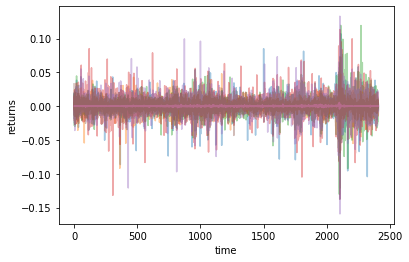

In [11]:
# (*) To communicate with Plotly's server, sign in with credentials file
import chart_studio.plotly as py 
from plotly.graph_objs import *

# (*) Useful Python/Plotly tools
import plotly.tools as tls   

# (*) Graph objects to piece together plots
from plotly.graph_objs import *
fig = plt.figure()
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')
#py.iplot_mpl(fig, filename='s6_damped_oscillation')

0.054008035661654845

In [12]:
FRED_Indicators = ['DTB4WK','DTB3','DTB6','DTB1YR']

import pandas_datareader.data as web

def Fred_Data(name):
    temp = web.DataReader(str(name), 'fred', start, end)
    temp.index = pd.to_datetime(temp.index)
    #temp = temp.resample(frequency).mean().dropna()
    return(temp)

FRED_set = []
FRED_completed = []
for i in FRED_Indicators:
    FRED_completed.append(i)
    FRED_set.append(Fred_Data(i))
                    
FRED_pvt = pd.DataFrame()

for x in range(0,len(FRED_completed)):
    values = FRED_set[x]
    #values.index = pd.to_datetime(FRED_set["DATE"])
    #values = values.resample(frequency).mean().dropna()
    #values['Symbol'] = x
    values = values.loc[~values.index.duplicated(keep='last')]
    #values = values.reset_index()

    FRED_pvt = pd.concat([FRED_pvt,values], axis=1)


In [1211]:
#FRED_pvt[(FRED_pvt.index>='2021-01-01')&(FRED_pvt.index<'2021-02-01')].dropna()

,DTB4WK,DTB3,DTB6,DTB1YR
DATE,,,,
2021-01-04,0.09,0.09,0.09,0.10
2021-01-05,0.08,0.09,0.09,0.10
2021-01-06,0.09,0.09,0.09,0.11
2021-01-07,0.09,0.09,0.09,0.11
2021-01-08,0.08,0.08,0.09,0.10
2021-01-11,0.09,0.08,0.10,0.10
2021-01-12,0.09,0.09,0.09,0.11
2021-01-13,0.09,0.09,0.10,0.12
2021-01-14,0.09,0.09,0.09,0.10


In [13]:
TREASURY_BILL_RATE =  FRED_pvt['DTB1YR'].dropna().values[-1]
print(TREASURY_BILL_RATE)

0.04


In [98]:
#Genetic Algorithm

n_portfolio = 100

bestSharpe = 0
runs = 0
weight = None
bestMean = 0
bestStd = 0
means = np.array([])
stds = np.array([])
sharpes = np.array([])
bestWeights = None
weights = np.array([])

for _ in range(n_portfolio):    
    means1, stds1, sharpes1, weights1 = np.column_stack([
        random_portfolio((TREASURY_BILL_RATE*1/252.75), return_vec, True, bestWeights)        
        for _ in range(len(symbols))
    ])
    means2, stds2, sharpes2, weights2 = np.column_stack([
        random_portfolio((TREASURY_BILL_RATE*1/252.75), return_vec, False)        
        for _ in range(len(symbols))
    ])    
    means_ = np.append(means1,means2)
    stds_ = np.append(stds1,stds2)
    sharpes_ = np.append(sharpes1,sharpes2)    
    weights_ = np.append(weights1,weights2)
    
    if(sharpes_.max()>bestSharpe):
        bestSharpe = sharpes_[sharpes_.argmax()]
        bestMean = means_[sharpes_.argmax()]
        bestStd = stds_[sharpes_.argmax()]
        #print(means_[sharpes_.argmax()])
        print(sharpes_[sharpes_.argmax()])
        #print(weights_[sharpes_.argmax()])
        bestWeights = weights_[sharpes_.argmax()]

    means = np.append(means,means_)
    stds = np.append(stds,stds_)
    sharpes = np.append(sharpes,sharpes_)
    weights = np.append(weights,weights_)
        

/mnt/distvol/Python-3.9.4/lib/python3.9/site-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



0.03322645778133579
0.04034290625945729
0.04787097019073019
0.0499524828128574
0.05151424712568248
0.053064586681725714


In [77]:
#optimal_risk_free_sharpe = optimize_sharpe_ratio(return_vec, 0)
optimal_risk_free_sharpe = get_ret_vol_sr(np.array(fq.EfficientFrontier(pd.Series(np.mean((np.exp(return_vec)-1)*1,axis=1)),pd.DataFrame(np.cov((np.exp(return_vec)-1)*1)),risk_free_rate=0, freq=1, method='SLSQP').maximum_sharpe_ratio()['Allocation']),return_vec)
#

0.0001582591493570722

,0
IBM,0.2597
GLD,0.330468
XOM,0.32375
AAPL,0.328879
MSFT,0.179305
TLT,0.875322
SHY,0.816392


Optimal Genetic Algorithm Expected Annual Return: 0.14070155407612495
Optimal Genetic Algorithm Expected Annual Variance: 1.904115575774683
Optimal Genetic Algorithm sharpe ratio: 0.053064586681725714


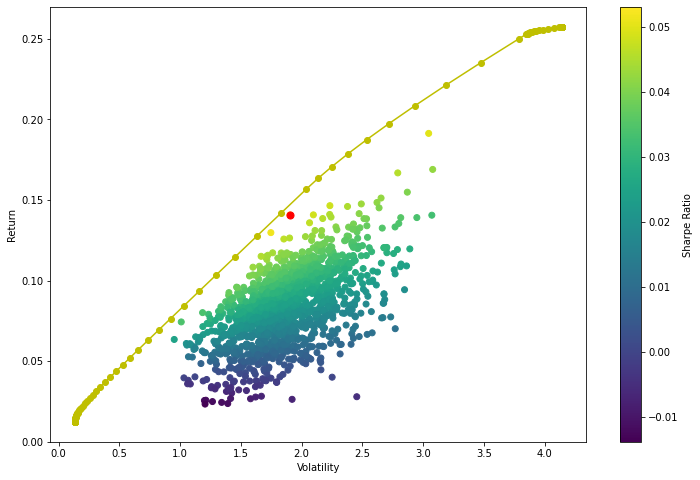

In [99]:
returns, risks = optimal_portfolio(return_vec)

#print('Its location in the array: {}'.format(sharpes.argmax()))

display(pd.DataFrame(weights[sharpes.argmax()]).set_index(np.array(symbols)))
max_sr_ret = means[sharpes.argmax()]
max_sr_vol = stds[sharpes.argmax()]
max_sharpe = sharpes[sharpes.argmax()]

print('Optimal Genetic Algorithm Expected Annual Return: {}'.format((np.exp(max_sr_ret)-1)*252.75))
print('Optimal Genetic Algorithm Expected Annual Variance: {}'.format((np.exp(max_sr_vol)-1)*252.75))
print('Optimal Genetic Algorithm sharpe ratio: {}'.format(max_sharpe))

plt.figure(figsize=(12,8))
plt.scatter((np.exp(stds.astype(float))-1)*252.75, (np.exp(means.astype(float))-1)*252.75, c=sharpes, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.plot((np.exp(risks)-1)*252.75, (np.exp(returns)-1)*252.75, 'y-o')
plt.scatter((np.exp(max_sr_vol)-1)*252.75, (np.exp(max_sr_ret)-1)*252.75,c='red', s=50) # red dot
#plt.scatter((np.exp(bestStd)-1)*252.75,(np.exp(bestMean)-1)*252.75,c='purple', s=50) # red dot
#plt.scatter((np.exp(optimal_risk_free_sharpe[1])-1)*252.75, (np.exp(optimal_risk_free_sharpe[0])-1)*252.75,c='purple', s=50) # red dot
plt.show()

,0,1,2,3,4,5,6
0,0.000212,0.000002,0.000120,0.000104,0.000116,-0.000039,-1.749161e-06
1,0.000002,0.000094,0.000004,0.000009,0.000005,0.000019,1.686941e-06
2,0.000120,0.000004,0.000242,0.000094,0.000100,-0.000045,-1.970654e-06
3,0.000104,0.000009,0.000094,0.000327,0.000166,-0.000039,-2.032406e-06
4,0.000116,0.000005,0.000100,0.000166,0.000264,-0.000035,-1.748139e-06
5,-0.000039,0.000019,-0.000045,-0.000039,-0.000035,0.000076,2.823033e-06
6,-0.000002,0.000002,-0.000002,-0.000002,-0.000002,0.000003,3.088354e-07


In [54]:
import finquant.efficient_frontier as fq
fq.EfficientFrontier(pd.Series(np.mean((np.exp(return_vec)-1)*252.75,axis=1)),pd.DataFrame(np.cov((np.exp(return_vec)-1)*252.75)),risk_free_rate=TREASURY_BILL_RATE, freq=252, method='SLSQP').maximum_sharpe_ratio().values

array([[0.00000000e+00],
       [0.00000000e+00],
       [3.72881407e-15],
       [1.39567642e-02],
       [2.15476807e-02],
       [0.00000000e+00],
       [9.64495555e-01]])

/mnt/distvol/Python-3.9.4/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



array([[[0.00053468]],

       [[0.00727045]],

       [[0.07354199]]])

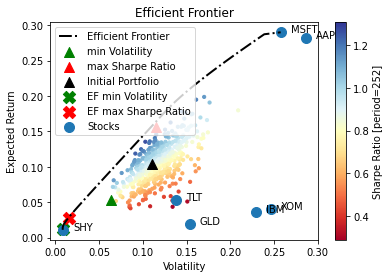

In [68]:
from finquant.portfolio import build_portfolio

pf = build_portfolio(data=stocks_df)

# performs and plots results of Monte Carlo run (5000 iterations)
opt_w, opt_res = pf.mc_optimisation(num_trials=500)
# plots the results of the Monte Carlo optimisation
pf.mc_plot_results()
# plots the Efficient Frontier
pf.ef_plot_efrontier()
# plots optimal portfolios based on Efficient Frontier
pf.ef.plot_optimal_portfolios()
# plots individual plots of the portfolio
pf.plot_stocks()

get_ret_vol_sr(opt_w.loc['Max Sharpe Ratio'].values,return_vec)

